# First Steps with Huggingface


In [1]:
from IPython.display import display, Markdown
with open('../../doc/env_variables_setup.md', 'r') as fh:
    content = fh.read()
display(Markdown(content))

Environment variables that need to be defined:   
`export DIR_PROJ=your_path_git_repository`  
`export PYTHONPATH=$DIR_PROJ/src`  
`export PATH_TENSORBOARD=your_path_tensorboard`  
`export PATH_DATASETS=your_path_datasets`  
`export PROJECT_ID=your_gcp_project_id`  
`export BUCKET_NAME=your_gcp_gs_bucket_name`  
`export REGION=your_region`  
`export MODEL_DIR_ESTIMATOR_PATH=your_path_to_save_model` 

- Use local Jupyter Lab 
    - you need to have the `jupyter-notebook` Anaconda python environment created [link](local_jupyter_lab_installation.md) 
    - you need to have the `jupyter-notebook` Anaconda python environment activated [link](local_jupyter_lab_installation.md) 
    - then define the environment variables above (copy and paste) 
    - you need to have the `env_multilingual_class` Anaconda python environment created [link](local_jupyter_lab_installation.md)  
    - start Jupyter Lab:  `jupyter lab` 
    - open a Jupyter Lab notebook from `notebook/` 
     - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - choose the proper Anaconda python environment:  `Python [conda env:env_multilingual_class]` [link](conda_env.md) 
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`


- Use GCP Jupyter Lab 
    - Go on GCP
    - open a Cloud Shell
    - `ssh-keygen -t rsa -b 4096 -C firstName_lastName`
    - `cp .ssh/id_rsa.pub .`
    - use Cloud Editor to edit this file `id_rsa.pub` and copy the full content
    - Go on Compute Engine -> Metadata
    - Click SSH Keys
    - Click Edit
    - Click + Add item, copy the content of `id_rsa.pub`
    - You should see firstName_lastName of the left
    - Click Save
    - you need to start a AI Platform instance 
    - open a Jupyter Lab terminal and got to `/home/gcp_user_name/`
    - clone this repositiory: `git clone https://github.com/tarrade/proj_multilingual_text_classification.git`
    - then `cd proj_multilingual_text_classification/`
    - create the Anacond Python environment `conda env create -f env/environment.yml`
    - create a file `config.sh` in `/home` with the following information: 
    ```
    #!/bin/bash
    
    echo "applying some configuration ..."
    git config --global user.email user_email
    git config --global user.name user_name
    git config --global credential.helper store
        
    # Add here the enviroment variables from above below
    # [EDIT ME]
    export DIR_PROJ=your_path_git_repository
    export PYTHONPATH=$DIR_PROJ/src
  
    cd /home/gcp_user_name/
    
    conda activate env_multilingual_class

    export PS1='\[\e[91m\]\u@:\[\e[32m\]\w\[\e[0m\]$'
    ```
    - Got to AI Platform Notebook, select your instance and click "Reset".
    - Wait and reshreh you Web browser with the Notebook


## Import Packages

In [2]:
# only running this cell leads to problems when kernel has not been restarted
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.data.ops import dataset_ops
from tensorboard.backend.event_processing import event_accumulator
from absl import logging
from datetime import datetime
import os
import shutil
import numpy as np
from tqdm import tqdm
import json


from transformers import (BertTokenizer,
                          glue_convert_examples_to_features,
                          TFBertForSequenceClassification,
                          TFBertModel,
                          TFBertForPreTraining)

## Define Paths

In [3]:
try:
    data_dir=os.environ['PATH_DATASETS']
except:
    print('missing PATH_DATASETS')

## Import local packages

In [55]:
import preprocessing.preprocessing as pp

In [57]:
import importlib
importlib.reload(pp);

## Loading a Dataset from Tensorflow

In [4]:
train_data, validation_data, test_data = tfds.load(name="imdb_reviews",
                                                   data_dir=data_dir,
                                                   split=('train[:60%]', 'train[60%:]', 'test'),
                                                   as_supervised=True)
# trying to extract the info
data_ex, data_ex_info = tfds.load(name="imdb_reviews",
                                                   data_dir=data_dir,
                                                   as_supervised=True,
                                                   with_info=True)

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imdb_reviews (/Users/tarrade/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split ('train[:60%]', 'train[60%:]', 'test'), from /Users/tarrade/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imdb_reviews (/Users/tarrade/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /Users/tarrade/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


## Exploring the Dataset

In [5]:
data_ex

{'test': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>,
 'unsupervised': <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.int64)>}

In [6]:
data_ex_info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [7]:
for i in data_ex['train']:
    print(i)
    break

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [8]:
data_ex['train'].element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [9]:
np_array=np.array(list(data_ex['train'].as_numpy_iterator()))

In [10]:
np_array[0][0]

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [11]:
np_array.shape

(25000, 2)

In [12]:
np_array[:,0]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

In [13]:
type(np_array[:,1])

numpy.ndarray

In [14]:
type(np_array[:,0])

numpy.ndarray

In [15]:
to_string = lambda t: t.decode("utf-8")

In [16]:
sentence=np_array[:,0].tolist()

In [17]:
sentence=list(map(to_string, sentence))

In [18]:
len(sentence)

25000

In [19]:
sentence[0:2]

["This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
 'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development wa

In [20]:
to_int = lambda t: int(t.decode("utf-8"))

In [21]:
label=np_array[:,1].tolist()

In [22]:
label=list(map(to_int, label))

In [23]:
label[0:10]

[0, 0, 0, 1, 1, 1, 0, 0, 0, 0]

In [24]:
idx=[j for j in range(0,len(label))]

In [25]:
len(idx)

25000

In [26]:
# {'idx': tf.int32, 'label': tf.int64, 'sentence': tf.string}
data_set = {'idx': idx, 'label': label, 'sentence': sentence}

In [27]:
#json_dump = json.dumps(data_set)

In [28]:
data_set.keys()

dict_keys(['idx', 'label', 'sentence'])

In [29]:
class InputFeatures(object):
    def __init__(self, idx, label,sentence):
        self.idx = idx
        self.sentence = sentence
        self.label = label

In [30]:
features=[]

In [31]:
for i,x  in enumerate(sentence):
    ##print(sentence[i],label[i],idx[i])
    #print(type(sentence[i]),type(label[i]),type(idx[i]))
    #break
          
    features.append(InputFeatures(np.int32(idx[i]), np.int64(label[i]), sentence[i]))

In [32]:
type(features)

list

In [33]:
def gen():
    for ex in features:
        yield ({"idx": ex.idx,
                "label": ex.label,
                "sentence": ex.sentence,
               })

In [34]:
gen

<function __main__.gen()>

In [35]:
my_data=tf.data.Dataset.from_generator(
    gen,
    ({"idx": tf.int32, "label": tf.int64, "sentence": tf.string}),
    ({"idx": tf.TensorShape([]),
      "label": tf.TensorShape([]),
      "sentence": tf.TensorShape([]),
     })
)

In [36]:
# <DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>
my_data

<FlatMapDataset shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

In [37]:
my_data.element_spec

{'idx': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}

In [38]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [39]:
my_transform_data=glue_convert_examples_to_features(my_data, tokenizer, max_length=128, task='sst-2')

In [40]:
my_transform_data

<FlatMapDataset shapes: ({input_ids: (None,), attention_mask: (None,), token_type_ids: (None,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

In [59]:
my_data2=pp.create_tf_example(idx, label, sentence)

In [60]:
my_data2.element_spec

{'idx': TensorSpec(shape=(), dtype=tf.int32, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'sentence': TensorSpec(shape=(), dtype=tf.string, name=None)}

In [61]:
my_transform_data2=glue_convert_examples_to_features(my_data2, tokenizer, max_length=128, task='sst-2')

In [62]:
my_transform_data2

<FlatMapDataset shapes: ({input_ids: (None,), attention_mask: (None,), token_type_ids: (None,)}, ()), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

### Statistical Analysis

In [41]:
len_element = []
for index, element in enumerate(train_data.as_numpy_iterator()): 
    len_element.append(len(element[0]))
   

In [42]:
import statistics as st
print("Longest sequence: ", max(len_element))
print("Shortest sequence: ", min(len_element))
print("Average: ", st.mean(len_element))
print("Standard deviation: ", st.stdev(len_element))

Longest sequence:  13704
Shortest sequence:  64
Average:  1323.1707333333334
Standard deviation:  997.3094992023667


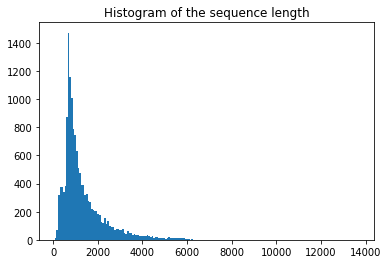

In [43]:
# plot the distribution of the length of the sequences
import matplotlib.pyplot as plt
_ = plt.hist(len_element, bins='auto')  
plt.title("Histogram of the sequence length")
plt.show()

Given the relatively large mean of the sequence length, choosing a max_length of 512 may not be appropriate and should be increased to 1024. This will increase the computation time, though.

*Is it an option to choose a relatively small max_length and still get good results?*

*Kick out outliers?*

In [44]:
# what do those really long sequences look like?


## Experimenting with Tokenizer

### Defining the Tokenizer Parameters

In [45]:
pretrained_weights = 'bert-base-cased'

In [46]:
#try out also different weights
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)


L: glue_convert_examples_to_features only works when a valid task is defined. This is only the case for specific data sets (found in GLUE).
What glue_convert_examples_to_features does is convert the data to a tf.dataset.

In [47]:
bert_tokenized_sequence = tokenizer.tokenize("Hello, I am looking for an embedding.")
bert_tokenized_sequence

['Hello', ',', 'I', 'am', 'looking', 'for', 'an', 'em', '##bed', '##ding', '.']

### Setting up the Data for the Tokenizer

In [48]:
# code from https://github.com/strongio/keras-bert/blob/master/keras-bert.py
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label
        

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label


# changed this to fit the input data better
def convert_text_to_examples(data):
    """Create InputExamples"""
    InputExamples = []
    for data in data:
        InputExamples.append(
            # need to access only the text here
            #InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples


def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

In [49]:
train_data_original = glue_convert_examples_to_features(data_original['train'], tokenizer, max_length=128, task='mrpc')

NameError: name 'data_original' is not defined

In [ ]:
print(type(train_data_original))

In [ ]:
#train_data_examples = convert_text_to_examples(train_data)

#train_data_tokenized = convert_examples_to_features(train_data, tokenizer, max_seq_length=128)


In [ ]:
#x = tf.cast(train_data, str)
#print(type(x))

In [ ]:
#train_data_encoded = tokenizer.encode_plus(train_data)

## Building the Model

In [ ]:
model = TFBertForSequenceClassification.from_pretrained(pretrained_weights)